# **Data Diri**
Nama : Ardian Nurcahya \\
Email : ardian.a1gca@gmail.com \\
Domisili : Bandung \\
Tempat, Tanggal Lahir : Bandung, 20 januari 2002 \\
Profesi saat ini : Mahasiswa \\
Institusi : Universitas Padjadjaran \\

# Membuat Model Machine Learning dengan Data Time Series *Apple Stock*

### 1. Mengimport pustaka yang dibutuhkan

In [1]:
# mengimport pustaka yang digunakan
import numpy as np
import pandas as pd
import os
from google.colab import drive
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

### 2. Menghubungkan kaggle dengan google drive

In [2]:
# Menginstall Kaggle
!pip install kaggle

# mount gdrive dan mengubah environment direktori
drive.mount('/content/gdrive')
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle"
%cd /content/gdrive/My Drive/Kaggle

Mounted at /content/gdrive
/content/gdrive/My Drive/Kaggle


In [ ]:
# Mengunduh dan mengekstrak Dataset
!kaggle datasets download -d meetnagadia/apple-stock-price-from-19802021
!unzip \*.zip && rm *.zip

100% 206k/206k [00:00<00:00, 667kB/s]
100% 206k/206k [00:00<00:00, 662kB/s]
Archive:  apple-stock-price-from-19802021.zip
  inflating: AAPL.csv                


### 3. Membaca dataset

In [3]:
df = pd.read_csv('AAPL.csv', delimiter=',')
print(f'Jumlah Sample data: {len(df)}')
df.head()

Jumlah Sample data: 10468


Date      Open      High       Low     Close  Adj Close     Volume
0  1980-12-12  0.128348  0.128906  0.128348  0.128348   0.100178  469033600
1  1980-12-15  0.122210  0.122210  0.121652  0.121652   0.094952  175884800
2  1980-12-16  0.113281  0.113281  0.112723  0.112723   0.087983  105728000
3  1980-12-17  0.115513  0.116071  0.115513  0.115513   0.090160   86441600
4  1980-12-18  0.118862  0.119420  0.118862  0.118862   0.092774   73449600

In [4]:
# mengecek nilai yang hilang pada dataset
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

### 4. Preprocessing data

In [5]:
# Menghapus kolom yang tidak dibutuhkan
df = df.drop(columns=['Open', 'High', 'Low','Adj Close', 'Volume'])
df.head()

Date     Close
0  1980-12-12  0.128348
1  1980-12-15  0.121652
2  1980-12-16  0.112723
3  1980-12-17  0.115513
4  1980-12-18  0.118862

In [6]:
# Menentukan data input
X = np.arange(len(df['Date']))
y = df['Close'].values

# Melakukan pembagian data 20% validation dan 80% training
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

### 5. Mengatur skala data berdasarkan nilai min dan max

In [7]:
# Scalling y
y_scaled = MinMaxScaler()
y_scaled.fit(y_train.reshape(-1, 1))
y_train_scaled = y_scaled.transform(y_train.reshape(-1, 1)).ravel()
y_scaled.fit(y_val.reshape(-1, 1))
y_val_scaled = y_scaled.transform(y_val.reshape(-1, 1)).ravel()

n_y_train = (y_train_scaled.max() - y_train_scaled.min())
n_y_val = (y_val_scaled.max() - y_val_scaled.min())

print(f'Rentang data: {np.round(n_y_train,2)}')
print(f'Threshold: {np.round(n_y_train*0.1,2)}')

Rentang data: 1.0
Threshold: 0.1


In [8]:
# Menerapkan moving window pada data time series
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    dsa = tf.data.Dataset.from_tensor_slices(series)
    ds = dsa.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

### 6. Pembuatan model sequential

In [9]:
# Membuat model dengan sequential
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(1),
])

# Menerapkan optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0e-04, momentum=0.9)

# Melaukan compiling model
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

### 7. Penerapan callbacks dan pelatihan model

In [10]:
# Callback yang digunakan
model_path = os.path.join('/content/gdrive/MyDrive/Kaggle', 'best_LSTM_model.h5')
save_best_model = tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', mode='max' , save_best_only=True)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

In [11]:
# dataset
y_train_set = windowed_dataset(y_train_scaled, window_size=120, batch_size=128, shuffle_buffer=1000)
y_val_set = windowed_dataset(y_val_scaled, window_size=60, batch_size=128, shuffle_buffer=1000)

# pelatihan model
history = model.fit(y_train_set,
                    epochs=200,
                    validation_data=y_val_set,
                    callbacks = [save_best_model,early_stop],
                    verbose=2)

Epoch 1/200
65/65 - 15s - loss: 0.0296 - mae: 0.1111 - val_loss: 0.0827 - val_mae: 0.2822 - 15s/epoch - 230ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/200
65/65 - 3s - loss: 0.0274 - mae: 0.1022 - val_loss: 0.0769 - val_mae: 0.2628 - 3s/epoch - 43ms/step
Epoch 3/200
65/65 - 2s - loss: 0.0258 - mae: 0.1068 - val_loss: 0.0719 - val_mae: 0.2464 - 2s/epoch - 38ms/step
Epoch 4/200
65/65 - 2s - loss: 0.0245 - mae: 0.1116 - val_loss: 0.0679 - val_mae: 0.2346 - 2s/epoch - 37ms/step
Epoch 5/200
65/65 - 4s - loss: 0.0234 - mae: 0.1157 - val_loss: 0.0646 - val_mae: 0.2261 - 4s/epoch - 60ms/step
Epoch 6/200
65/65 - 2s - loss: 0.0226 - mae: 0.1196 - val_loss: 0.0617 - val_mae: 0.2198 - 2s/epoch - 38ms/step
Epoch 7/200
65/65 - 3s - loss: 0.0221 - mae: 0.1224 - val_loss: 0.0591 - val_mae: 0.2146 - 3s/epoch - 43ms/step
Epoch 8/200
65/65 - 3s - loss: 0.0215 - mae: 0.1241 - val_loss: 0.0568 - val_mae: 0.2105 - 3s/epoch - 42ms/step
Epoch 9/200
65/65 - 5s - loss: 0.0209 - mae: 0.1253 - val_loss: 0.0548 - val_mae: 0.2070 - 5s/epoch - 69ms/step
Epoch 10/200
65/65 - 2s - loss: 0.0204 - mae: 0.1265 - val_loss: 0.0531 - val_mae: 0.2039 - 2s/epoch - 3

### 8. Mendapatkan performa model dan membuat plot

In [26]:
mae = history.history['mae']
val_mae = history.history['val_mae']
# Menampilkan hasil akurasi training dan test
print(f"mae: {round((mae[-1]/n_y_train)*100,3)} %")
print(f'validation mae: {round(val_mae[-1]/n_y_val,4)*100} %')

mae: 3.498 %
validation mae: 3.38 %


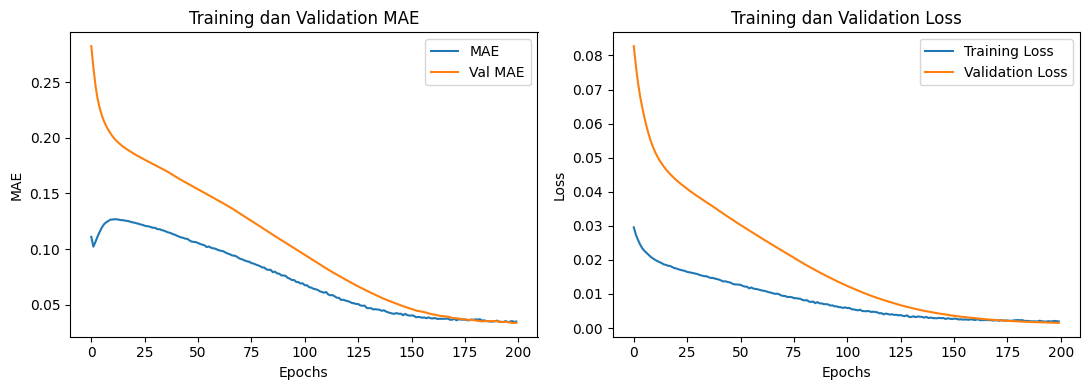

In [13]:
# Membuat Plot kurva loss
plt.figure(figsize=(11,4))
plt.subplot(1, 2, 1)
plt.plot(history.history['mae'], label='MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('Training dan Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

# Membuat Plot kurva akurasi
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training dan Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Menampilkan plot
plt.tight_layout()  # Untuk memberikan padding yang memadai antara subplot
plt.show()
